In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

%matplotlib inline

In [2]:
class LogisticBatchRegressor:
    
    def __init__(self, n_iter, eta, random_state, 
                 learning_schedule, cost_ratio=10):
        """
        n_iter: int. 
                Number of times to perform gradient descent. Epochs
        eta: float. 
                Learning rate. 
        random_state: int
                To reproduce results
        learning_schedule: function
                Function to change the learning rate
        """
        
        self.n_iter = n_iter
        self.eta = eta
        self.random_state = random_state
        self.cost_ratio = cost_ratio
        self.learning_schedule = learning_schedule
        
    def fit(self, X, y, batch_size):
        
        self.X = X
        self.y = y
        self.batch_size = batch_size
    
        assert batch_size <= len(X), 'The batch size must be smaller or equal than length of X'
        
        n_samples, n_features = X.shape
        self.__random_initialization(n_features)
        self.costs_ = []
        
        batches_gen = self.__yield_mini_batches()

        for epoch in range(self.n_iter):
            x, y = next(batches_gen)
            self.__forward(x)

            cost = self._compute_cost(y)
            
            if not epoch % self.cost_ratio:
                self.costs_.append(cost)
            self.__update_weights(m=n_features, y=y, x=x)
            self.eta = self.learning_schedule(epoch)
            
        return self
    
    def predict(self, X):
        net_input = self.net_input(X)
        sigmoid = self.sigmoid(net_input)
        return np.where(sigmoid >= 0.5, 1, 0).squeeze()
    
    def __forward(self, X):
        net_input = self.net_input(X)
        self.Z = self.sigmoid(net_input)
    
    def __backward(self, y):
        return self.Z - y
    
    def __yield_mini_batches(self):
        X = self.X.copy()
        y = self.y.copy()
        
        while True:
            
            random_index = np.random.choice(range(0, len(X)), size=len(X), replace=False)
            X = X[random_index]
            y = y[random_index]
            
            batch_random_index = np.random.choice(range(0, self.batch_size), 
                                                  size=self.batch_size, replace=False)
            
            mini_batch_data = X[batch_random_index]
            mini_batch_prediction = y[batch_random_index]
            
            yield mini_batch_data, mini_batch_prediction
    
    def __random_initialization(self, features):
        self.w_ = np.random.rand(features, 1)
        self.b_ = np.random.rand()
        
    def _compute_cost(self, y):
        m = len(self.w_)
        J = - 1 / m * np.sum((y * np.log(self.Z) + (1.0 - y) * np.log(1.0 - self.Z)))
        return J
    
    def __update_weights(self, m, y, x):
        dZ = self.__backward(y)
        self.w_ -= 1 / m * self.eta * np.dot(x.T, dZ.T)
        self.b_ -=  1 / m * self.eta * np.sum(dZ)
        
    def net_input(self, x):
        return np.dot(self.w_.T, x.T) + self.b_
    
    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    
    def __repr__(self):
        return (f"LogisticMBR(eta={np.round(self.eta, decimals=3)}, " + 
               f"n_iter={self.n_iter}, batch_size={self.batch_size})")

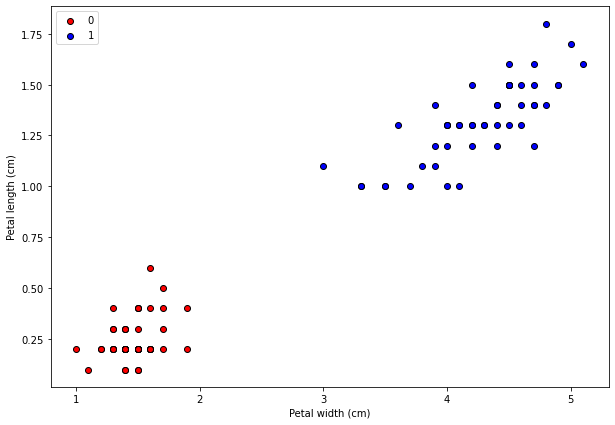

In [3]:
iris = load_iris()
X = iris.data[:100, (2, 3)]
y = iris.target[:100]

plt.figure(figsize=(10, 7))

colors = ['red', 'blue']
for label, color in zip(np.unique(y), colors):
    plt.scatter(X[y == label, 0], X[y == label, 1], c=color, 
                edgecolor='black', label=label)
    
plt.xlabel('Petal width (cm)')
plt.ylabel('Petal length (cm)')
plt.legend()
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=1)

print('Train size: ', len(X_train))
print('Test size: ', len(X_test))

print('Distribution of y_train: ', np.bincount(y_train))
print('Distribution of y_test: ', np.bincount(y_test))

Train size:  70
Test size:  30
Distribution of y_train:  [36 34]
Distribution of y_test:  [14 16]


In [5]:
def learning_schedule(t):
    t0, t1 = 5, 50
    return t0 / (t1 + t)

neuron = LogisticBatchRegressor(n_iter=1000, eta=0.01, 
                                random_state=1, learning_schedule=learning_schedule)
neuron.fit(X_train, y_train, 10)

LogisticMBR(eta=0.005, n_iter=1000, batch_size=10)

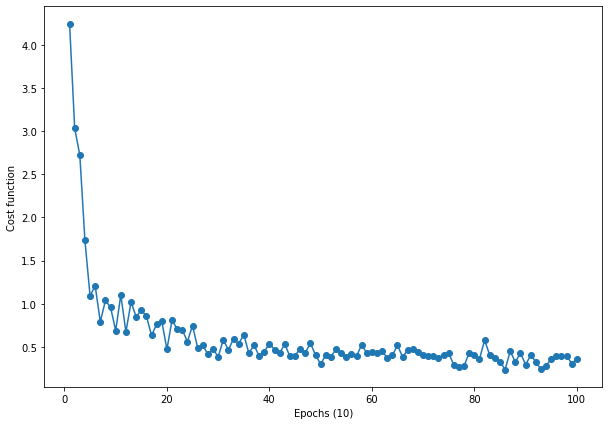

In [6]:
costs = neuron.costs_
cost_ratio = neuron.cost_ratio

plt.figure(figsize=(10, 7))
plt.plot(range(1, len(costs) + 1,), costs, 'o-')

#plt.xscale('log')
plt.xlabel(f'Epochs ({cost_ratio})')
plt.ylabel('Cost function')
plt.show()

In [7]:
from sklearn.metrics import accuracy_score

y_test_pred = neuron.predict(X_test)
print('Test accuracy: ', accuracy_score(y_test_pred, y_test))

Test accuracy:  1.0


In [8]:
def plot_decision_region(X, y, classifier, test_indx=range(100, 150), 
                         margin=1, resolution=0.02):
    
    from matplotlib.colors import ListedColormap
    colors = ['blue', 'red']
    cmap = ListedColormap(colors)
    
    x1_min, x1_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    x2_min, x2_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    
    X1, X2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), 
                         np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape)
    
    plt.figure(figsize=(10, 7))
    plt.contourf(X1, X2, Z, cmap=cmap, alpha=0.3)
    
    for label, color in zip(np.unique(y), colors):
        plt.scatter(X[y == label, 0], X[y == label, 1], c=color, 
                    label=label, edgecolor='black')
        
    if test_indx:
        X = X[test_indx]
        y = y[test_indx]
        for label, color in zip(np.unique(y), colors):
            plt.scatter(X[y == label, 0], X[y == label, 1], 
                        c=[], s=200, edgecolor=color, ls='--', 
                        label=f'test {label}')
            
            
    plt.legend()
    plt.show()

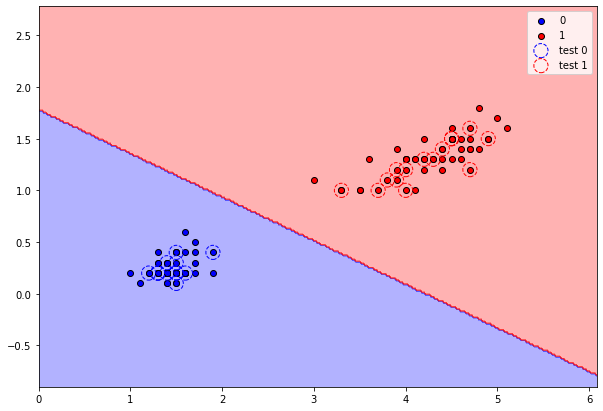

In [9]:
X_stacked = np.vstack((X_train, X_test))
y_stacked = np.hstack((y_train, y_test))

plot_decision_region(X_stacked, y_stacked, neuron, test_indx=range(70, 100))